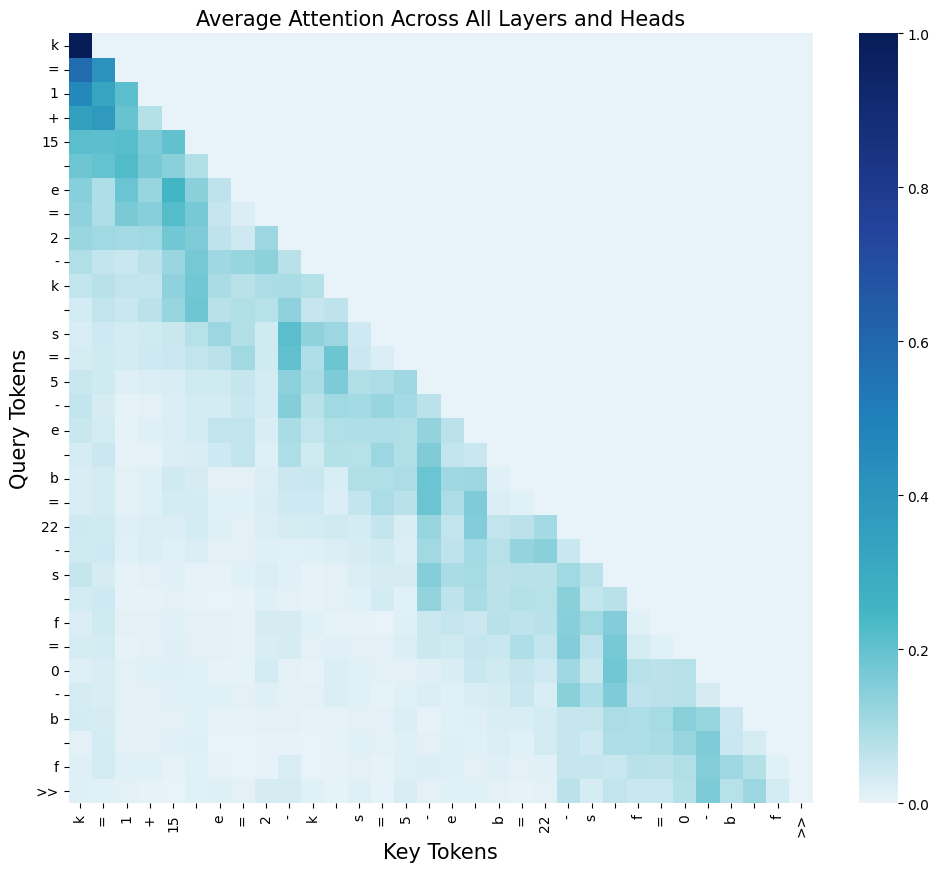

In [ ]:
import sys
sys.path.append('../model')
import torch
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
from modeling_gpt2_rope import GPT2LMHeadModelWithRoPE, GPT2ModelWithRoPE
from configuration_gpt2_rope import GPT2WithRoPEConfig
AutoConfig.register("gpt2-rope", GPT2WithRoPEConfig)
AutoModelForCausalLM.register(GPT2WithRoPEConfig, GPT2LMHeadModelWithRoPE)
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

path='YOUR_MODEL_PATH'
model = AutoModelForCausalLM.from_pretrained(path, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(path)
model.eval()

text = 'k=1+15\ne=2-k\ns=5-e\nb=22-s\nf=0-b\nf>>'
inputs = tokenizer.encode(text, return_tensors='pt')

with torch.no_grad():
    outputs = model(inputs, output_attentions=True)
attentions = outputs.attentions  

attentions = torch.stack(attentions)  # shape: (num_layers, batch, num_heads, seq_len, seq_len)
attentions = attentions.squeeze(1)     # shape: (num_layers, num_heads, seq_len, seq_len)
mean_attention = attentions.mean(dim=0).mean(dim=0)  # shape: (seq_len, seq_len)
mean_attention = mean_attention.cpu().numpy()

tokens = tokenizer.convert_ids_to_tokens(inputs[0])
tokens = [item if item!='Ċ' else '\n' for item in tokens ]

plt.figure(figsize=(12, 10))
cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", ['#e8f3f9','#41b5c4','#2080b9', '#24429b','#071d59'])
ax = sns.heatmap(mean_attention, xticklabels=tokens, yticklabels=tokens, cmap=cmap)  

plt.xlabel('Key Tokens',fontsize=15)
plt.ylabel('Query Tokens',fontsize=15)
plt.title('Average Attention Across All Layers and Heads',fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()